# Group Project 4 - Team T.W. Schultz


### Team Members: Neha Lala (*Team Manager*), Gavin Armstrong, Dojun Kim, Samantha Wang, Daniela Salinas Gomez

## **1.3 [A] Unit Test:**
## **1.8 [B] Policy Options**
## **1.9 [C] Policy Cost**
## **1.10 [C] Value of Technical Innovation.**
## **1.12 [A] Replication & Discussion**


## **Project Topic & Goal:**

Our project focuses on analyzing the nutrition breakdown in Guatemala by region (rural or urban) and, household size. We dive deep into demand for food within the groups broken down by the specified criteria and are focused on evaluating what kinds of policies might be effective at improving outcomes for particular populations with specific regards to nutritional staples. Typically, the food people choose to eat may be quite different from the foods that people should eat, from a nutritional perspective and our policies aim at closing the bag between the current nutritional consumption levels and the recommended levels of nutrient intake.

## **1.1 [A] Replicability & Documentation:**
### *Importing Packages*:


In [ ]:
!pip install eep153_tools
!pip install CFEDemands --upgrade --pre
!pip install -r requirements.txt


import cfe
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
from cfe.estimation import drop_columns_wo_covariance
from cfe import Regression
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import cfe.regression as rgsn


## **1.4 [A] Choice of a dataset:**

In [2]:
InputFiles = {'Expenditures':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Food Expenditures'),
              'Prices':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Transposed'),
              'HH Characteristics':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','Household Characteristics'),
              'FCT':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','FCT'),
              'RDI':('1x6A8fRQXzrdhzOV2UZTxzqhFfA-pt7T_sTmMNcQu_VQ','RDI') }

In [3]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures for each level of 
expenditures = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])
if 'm' not in expenditures.columns:
    expenditures['m'] = 1

expenditures = expenditures.set_index(['i','t','m'])
expenditures.columns.name = 'j'

expenditures = expenditures.apply(lambda expenditures: pd.to_numeric(expenditures,errors='coerce'))
expenditures = expenditures.replace(0,np.nan)

# hhc is short for HH Characteristics 
hhc = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in hhc.columns:
    hhc['m'] = 1

hhc = hhc.set_index(['i','t','m'])
hhc.columns.name = 'k'

hhc = hhc.apply(lambda expenditures: pd.to_numeric(expenditures,errors='coerce'))

# Get prices
prices = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in prices.columns:  # Supply "market" indicator if missing
    prices['m'] = 1

prices = prices.set_index(['t','m'])
prices.columns.name = 'j'

prices = prices.apply(lambda expenditures: pd.to_numeric(expenditures,errors='coerce'))
prices = prices.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])


fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda expenditures: pd.to_numeric(expenditures,errors='coerce'))

rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [4]:
expenditures.head()

,,j,Cooking Oil,Water (bottle),Avocado,Mineral Water,Garlic,Mushrooms,Celery,Rice,Peas,Corn Atole,...,Tea,Tomatoes,Tortillas,Tostadas,Beef Entrails,Chicken Giblets,Yogurt,Yucca,Carrots,Leafcutter Ants and Other Insect
i,t,m,,,,,,,,,,,,,,,,,,,,,
1,2000,Metropolitana,7.5,20.0,5.0,6.00,1.00,NaN,2.0,5.0,NaN,NaN,...,7.0,9.0,60.0,NaN,NaN,21.0,NaN,NaN,3.6,NaN
10,2000,Metropolitana,15.0,15.0,30.0,NaN,2.00,20.0,2.0,10.0,NaN,NaN,...,8.5,14.0,30.0,NaN,30.0,12.5,NaN,NaN,7.5,NaN
100,2000,Metropolitana,13.0,10.5,NaN,16.00,0.25,NaN,2.0,6.5,NaN,2.0,...,NaN,2.5,4.0,NaN,16.0,NaN,NaN,NaN,3.0,NaN
1000,2000,Central,9.5,10.0,NaN,NaN,1.50,NaN,1.5,10.0,NaN,NaN,...,NaN,9.0,60.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN
1001,2000,Central,10.0,20.0,5.0,7.75,1.00,NaN,2.0,5.0,2.0,4.0,...,22.0,6.0,37.5,NaN,12.0,NaN,NaN,1.0,3.5,NaN


In [5]:
hhc.head()

,,k,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99
i,t,m,,,,,,,,,,,,,,
1,2000,Metropolitana,0,1,0,0,0,0,0,0,1,1,0,1,0,0
2,2000,Metropolitana,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,2000,Metropolitana,0,0,0,0,2,0,0,0,1,0,1,1,1,0
4,2000,Metropolitana,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,2000,Metropolitana,0,0,1,0,0,0,0,0,0,0,1,1,0,0


In [6]:
prices.head()

j                   Cooking Oil  Water (bottle)   Avocado  Mineral Water  \
t    m                                                                     
2000 Central           5.010737        0.454545  1.865672       2.750779   
     Metropolitana     5.368647        0.240500  3.544776       2.731270   
     Noroccidente      4.545454        0.240500  1.492537       3.209243   
     Norte             5.368647        0.240500  1.492537       3.209243   
     Peten             5.000000        0.300625  1.492537       3.851091   

j                     Garlic  Mushrooms    Celery  Rice  Peas  Corn Atole  \
t    m                                                                      
2000 Central        4.545455         12  2.262490  2.50   3.0    1.801802   
     Metropolitana  4.545455         26  3.000000  2.50   6.0    2.702703   
     Noroccidente   4.545455          7  2.265861  2.25   2.5    1.801802   
     Norte          3.787879          4  2.000000  2.50   2.5    1.801802   
     Peten          9.090909          5  3.000000  2.50   4.0    1.801802   

j                   ...        Tea  Tomatoes  Tortillas  Tostadas  \
t    m              ...                                             
2000 Central        ...   8.341667       1.5   1.250000  7.500000   
     Metropolitana  ...   7.500000       2.0   1.041667  6.683929   
     Noroccidente   ...   9.895834       2.0   1.041667  2.000000   
     Norte          ...  12.500000       2.0   1.041667  5.000000   
     Peten          ...        NaN       NaN        NaN       NaN   

j                   Beef Entrails  Chicken Giblets    Yogurt     Yucca  \
t    m                                                                   
2000 Central                  7.5              4.0  8.227273  2.000000   
     Metropolitana           10.0              4.5  9.090909  2.500000   
     Noroccidente             6.0              4.0  8.181818  1.000000   
     Norte                    7.0              4.0  7.272727  1.339286   
     Peten                    NaN              NaN       NaN       NaN   

j                    Carrots  Leafcutter Ants and Other Insect  
t    m                                                          
2000 Central        1.063830                               8.0  
     Metropolitana  1.063830                               NaN  
     Noroccidente   0.638298                               4.5  
     Norte          2.127660                               NaN  
     Peten               NaN                               NaN  

[5 rows x 96 columns]

In [7]:
fct.head()

n,Water (hg),Water,Energy (hg),Energy,Protein (hg),Protein,Total Fat,Carbohydrate (hg),Carbohydrate,Fiber (hg),...,Zinc,Magnesium,Magnesium HG,Vitamin B-6 (hg),Vitamin B-6,Vitamin B-12,Vitamin B-12 (hg),Ac. Fólico,Folato Equiv. FD,Fracción Comestible (hg)
j,,,,,,,,,,,,,,,,,,,,,
Atol de Maiz,0.00,0.0,376,3760,33.50,335.0,0.70,89.2,892.0,NaN,...,0.0,0.0,NaN,0.25,2.5,6.0,0.60,20.0,NaN,10.0
Carne de Cerdo,72.23,722.3,143,1430,214.30,2143.0,5.66,0.0,0.0,0.0,...,18.4,230.0,23.0,0.53,5.3,6.3,0.63,0.0,5.0,7.0
Carne de Cerdo con Hueso,59.39,593.9,282,2820,16.12,161.2,23.58,0.0,0.0,0.0,...,23.1,160.0,16.0,0.40,4.0,8.2,0.82,0.0,4.0,6.2
Chicharrones de Cerdo,2.90,29.0,660,6600,20.80,208.0,56.10,16.8,168.0,NaN,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,10.0
Chiles,77.90,779.0,84,840,3.30,33.0,2.10,15.4,154.0,NaN,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,10.0


In [8]:
rdi.head()

k,Females 00-03,Males 00-03,Females 04-08,Males 04-08,Females 09-13,Males 09-13,Females 14-18,Males 14-18,Females 19-30,Males 19-30,Females 31-50,Males 31-50,Females 51-99,Males 51-99
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


## **1.5 [A] Estimate Demand System:**

In [9]:
import cfe

result = cfe.Regression(y=np.log(expenditures.stack()),d=hhc)

result.get_beta().sort_values(ascending=False)
result.to_pickle('./foo.pickle')
result = cfe.read_pickle('foo.pickle')
result.predicted_expenditures()

i     t     m              j             
1     2000  Metropolitana  Avocado             7.088698
                           Bananas            16.067197
                           Beans               9.494430
                           Beef              100.138098
                           Beef Entrails      13.948086
                                                ...    
7276  2000  Suroriente     Tostadas            9.664286
                           Water (bottle)     11.366774
                           Watermelon          7.872758
                           Wheat Flour         4.710398
                           Yucca               3.394201
Length: 515736, dtype: float64

## **1.6 [A] Construct Nutrient System:**

In [10]:
result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

g_ex = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
guat_q= (g_ex.unstack('j')/prices).dropna(how='all')

# Drop missing columns
guat_q = guat_q.loc[:,guat_q.count()>0]


In [11]:
work = fct.index.intersection(guat_q.columns)


nutrients = guat_q[work]@fct.loc[work,:]
hhc = hhc[rdi.columns.tolist()]

hh_rdi = hhc@rdi.T

# Uganda RDI is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7


In [12]:
hh_rwi

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,
1,2000,Metropolitana,50400.0,1127.0,705.6,9450.0,25900.0,3640.0,357.0,7770.0,350.0,17920.0,119700.0,28.0,27.3,18200.0,56.7,30.8,1785.0,357.0,2310.0,210.0
2,2000,Metropolitana,40600.0,1106.0,568.4,8400.0,22400.0,2730.0,168.0,8120.0,322.0,14700.0,98700.0,25.9,24.5,17500.0,50.4,31.5,1785.0,315.0,2310.0,210.0
3,2000,Metropolitana,84000.0,1974.0,1176.0,15400.0,46200.0,5460.0,406.0,14280.0,602.0,37100.0,194600.0,47.6,45.5,32200.0,92.4,53.2,3045.0,574.0,3990.0,399.0
4,2000,Metropolitana,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,2240.0,98.0,4900.0,32900.0,7.7,7.7,4900.0,16.8,10.5,525.0,105.0,630.0,56.0
5,2000,Metropolitana,37800.0,847.0,529.2,7000.0,21000.0,2730.0,252.0,6090.0,266.0,13300.0,92400.0,21.0,20.3,14000.0,42.0,22.4,1330.0,259.0,1855.0,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7272,2000,Suroriente,11200.0,322.0,156.8,2800.0,8400.0,910.0,56.0,2240.0,98.0,4900.0,32900.0,7.7,7.7,4900.0,16.8,10.5,525.0,105.0,630.0,56.0
7273,2000,Suroriente,56000.0,1071.0,784.0,9450.0,32900.0,4550.0,371.0,7350.0,364.0,20020.0,140000.0,28.7,28.0,18900.0,56.7,30.1,1610.0,350.0,2450.0,224.0
7274,2000,Suroriente,81200.0,1736.0,1136.8,15050.0,53200.0,6370.0,518.0,12530.0,574.0,42770.0,209300.0,44.1,43.4,29400.0,90.3,48.3,2520.0,560.0,3430.0,364.0


In [13]:
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients].fillna(0)/hh_rwi[use_nutrients]).dropna()

<Axes: >

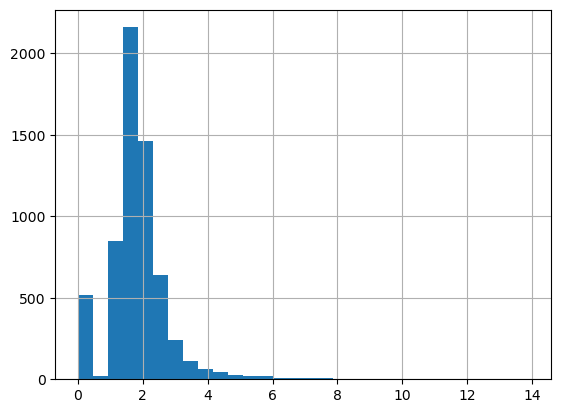

In [14]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)

In [15]:
((nutrient_ratio['Energy']) < 1).mean()

0.09029454369869629

<Axes: >

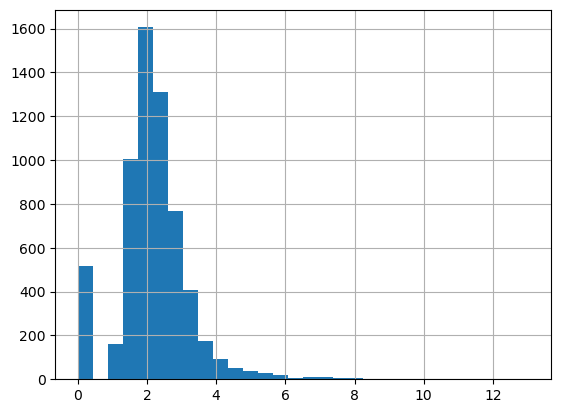

In [16]:
%matplotlib inline
nutrient_ratio['Protein'].hist(bins=30)

In [17]:
((nutrient_ratio['Protein']) < 1).mean()

0.08466119427007887

<Axes: >

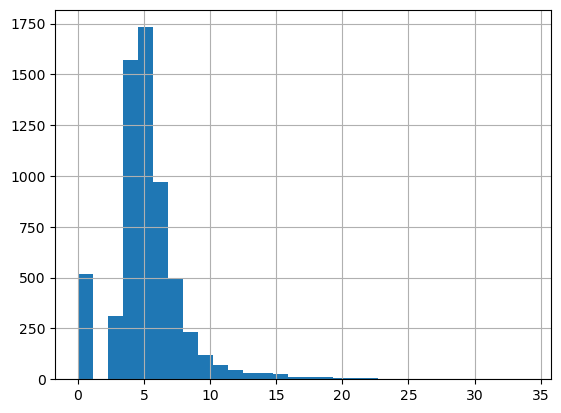

In [62]:
%matplotlib inline
nutrient_ratio['Carbohydrate'].hist(bins=30)

In [61]:
((nutrient_ratio['Protein']) < 1).mean()

0.08466119427007887

<Axes: >

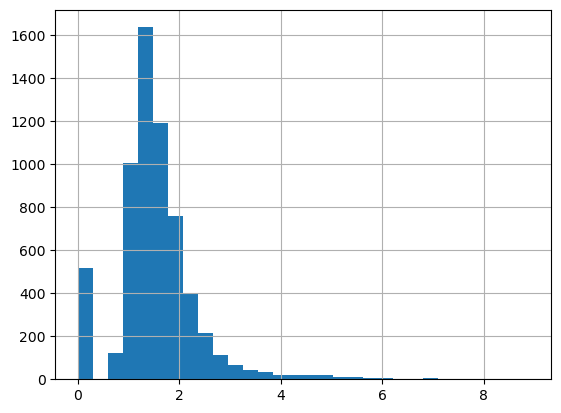

In [63]:
%matplotlib inline
nutrient_ratio['Calcium'].hist(bins=30)

In [64]:
((nutrient_ratio['Calcium']) < 1).mean()

0.13906325446644133

In [18]:
dbar = result.d[rdi.columns].mean()
dbar

k
Females 00-03    0.333186
Males 00-03      0.342175
Females 04-08    0.396699
Males 04-08      0.400383
Females 09-13    0.339228
Males 09-13      0.359416
Females 14-18    0.301356
Males 14-18      0.308429
Females 19-30    0.507073
Males 19-30      0.439287
Females 31-50    0.510021
Males 31-50      0.443118
Females 51-99    0.290746
Males 51-99      0.270557
dtype: float64

In [19]:
import numpy as np
g_ex = result.predicted_expenditures()

# Total food expenditures per household
xbar = g_ex.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)
x0


985.1501953756577

In [33]:
#Select price in year 2000 as reference price
pbar = prices[prices.index.get_level_values('t') == 2000].describe().iloc[5,:] #select medians as prices
pbar = pbar.dropna()
pbar

j
Cooking Oil                         5.010737
Water (bottle)                      0.245700
Avocado                             1.492537
Mineral Water                       3.209243
Garlic                              4.545455
                                      ...   
Chicken Giblets                     4.000000
Yogurt                              7.727273
Yucca                               1.750000
Carrots                             1.063830
Leafcutter Ants and Other Insect    4.750000
Name: 50%, Length: 96, dtype: float64

In [57]:
qhat = (g_ex.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Avocado,Bananas,Beans,Beef,Beef Entrails,Beer,Beets,Bread (french),Bread (sliced),Bread (sweet),...,Spices,Sweets,Tomato Sauce,Tomatoes,Tortillas,Tostadas,Water (bottle),Watermelon,Wheat Flour,Yucca
i,t,m,,,,,,,,,,,,,,,,,,,,,
1,2000,Metropolitana,4.749428,7.326642,3.797772,2.945238,1.799753,3.347937,2.759191,11.180253,7.519554,13.806255,...,0.213787,0.758592,0.951226,3.921614,31.750634,1.441952,71.148461,6.885508,2.755326,1.358946
2,2000,Metropolitana,6.062901,10.115117,4.853161,3.688486,2.128172,4.977795,3.500520,14.666603,11.811742,15.715097,...,0.372959,0.966888,1.257889,5.126006,34.149674,1.706571,90.169162,6.967681,3.929406,1.807151
3,2000,Metropolitana,11.400198,19.330926,8.679982,8.246768,3.239258,7.421310,4.674966,26.905169,17.161760,32.016508,...,0.536575,2.337291,1.925601,9.195305,67.380789,3.232877,114.845725,11.479992,5.872317,2.885940
5,2000,Metropolitana,9.112109,15.888487,4.929910,5.736534,2.516475,6.082334,4.351104,22.901207,12.239149,23.919126,...,0.454732,1.741857,1.526911,6.552247,35.650304,2.265894,120.233466,10.521178,5.427656,2.030596
6,2000,Metropolitana,6.912582,13.189469,5.662749,4.177010,2.669636,4.572270,3.919132,15.400435,9.757337,17.184167,...,0.453342,1.295864,1.411346,6.524073,42.712880,2.105888,117.738814,10.214019,4.109628,1.953787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7271,2000,Suroriente,2.851391,3.240333,5.764016,1.036824,1.440405,4.619042,2.295490,4.268715,6.643225,10.210250,...,0.157165,0.471409,0.641718,2.179649,40.128685,1.017771,36.391021,5.735692,1.507867,1.508593
7272,2000,Suroriente,2.650392,3.065596,3.316170,0.817672,1.123361,3.833623,2.071562,3.943573,5.624827,7.447927,...,0.135849,0.356063,0.610986,1.633256,24.615142,0.822420,37.069159,4.404227,1.610950,1.031232
7273,2000,Suroriente,13.250928,24.478989,10.516073,6.677561,3.859473,14.674917,6.844837,20.595623,17.743761,42.318833,...,0.815498,2.797715,1.916343,8.827101,63.970380,3.218270,117.625066,19.205214,5.801844,3.916677


## **1.7 [A] Nutritional challenges & Policy Goal:**


In [28]:
nutrient_ratio.columns

Index(['Energy', 'Protein', 'Carbohydrate', 'Fiber', 'Folate', 'Calcium',
       'Phosphorus', 'Iron', 'Thiamin', 'Niacin', 'Vitamin C', 'Vitamin A',
       'Potassium', 'Zinc', 'Magnesium', 'Vitamin B-6', 'Vitamin B-12'],
      dtype='object', name='n')

Text(0, 0.5, 'Ratio of recomended nutrients over actual consumption')

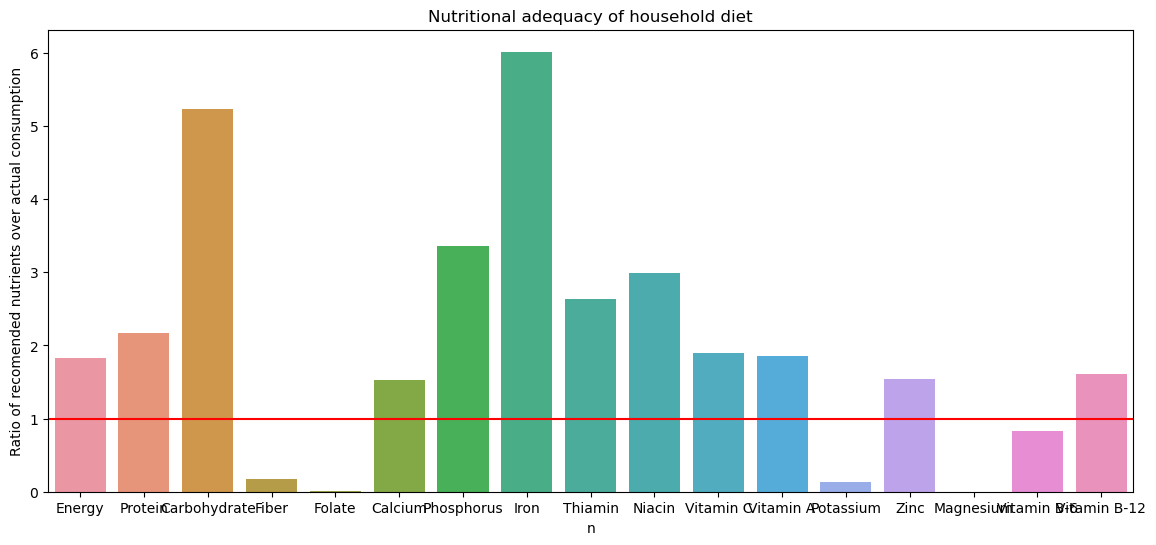

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
sns.barplot(x=nutrient_ratio.mean().index, y=nutrient_ratio.mean())
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.title("Nutritional adequacy of household diet")
plt.ylabel("Ratio of recomended nutrients over actual consumption")

From plot above, we can see that Guatemalans experience a deficiency in fiber, folate, potassium, magnesium, and vitamin B-6 which are all different kinds of vitamin B. Vitamin B is abundant in meat, eggs, and diary products.

